In [135]:
import numpy as np
from matplotlib.pyplot import *
from tqdm import tqdm

from prospect.models.templates import TemplateLibrary
from prospect.models.transforms import tburst_from_fage
from astropy.cosmology import Planck13

from prospectFunctionsSFH import *

from prospect.plotting.sfh import parametric_sfr

In [146]:
run_params = {}
run_params['zred'] = 3.548
run_params['mass'] = 1e8
run_params['logzsol'] = 0.0 # Solar metallicity
run_params['dust2'] = 0.0
run_params['sfh'] = 1 # tau model plus a constant component and a burst
run_params['tage'] = 1 # The age of the host (galaxy) in Gyrs
run_params['imf_type'] = 2 # (Kroupa 2001)
run_params['tau'] = .05 # The e-folding time for the SFH, range is 1e-1 to 1e2

run_params['add_burst'] = True
# run_params['tburst']
run_params['fburst'] = 0.1 # The fraction of mass formed in an instantaneous burst of star formation
run_params['fage_burst'] = 0.4 # The fraction of the host age at which the burst occurred.
run_params['tburst'] = tburst_from_fage(**run_params) # The age of the universe (age of the host) when the burst occurred

run_params['const'] =  0.8 - run_params['fburst']

run_params['trunc'] = True
run_params['sf_start'] = 0.2 # Start time of the SFH in Gyrs
run_params['sf_trunc'] = 0.9 # Trunctation time of the SFH in Gyrs. 0.0 => no trunctation
# run_params['sf_slope'] # For sfh=5, this is the slope of the SFR *after* time sf_trunc

obs = getObs()
sps = getSps(**run_params)

model = getModel(**run_params)

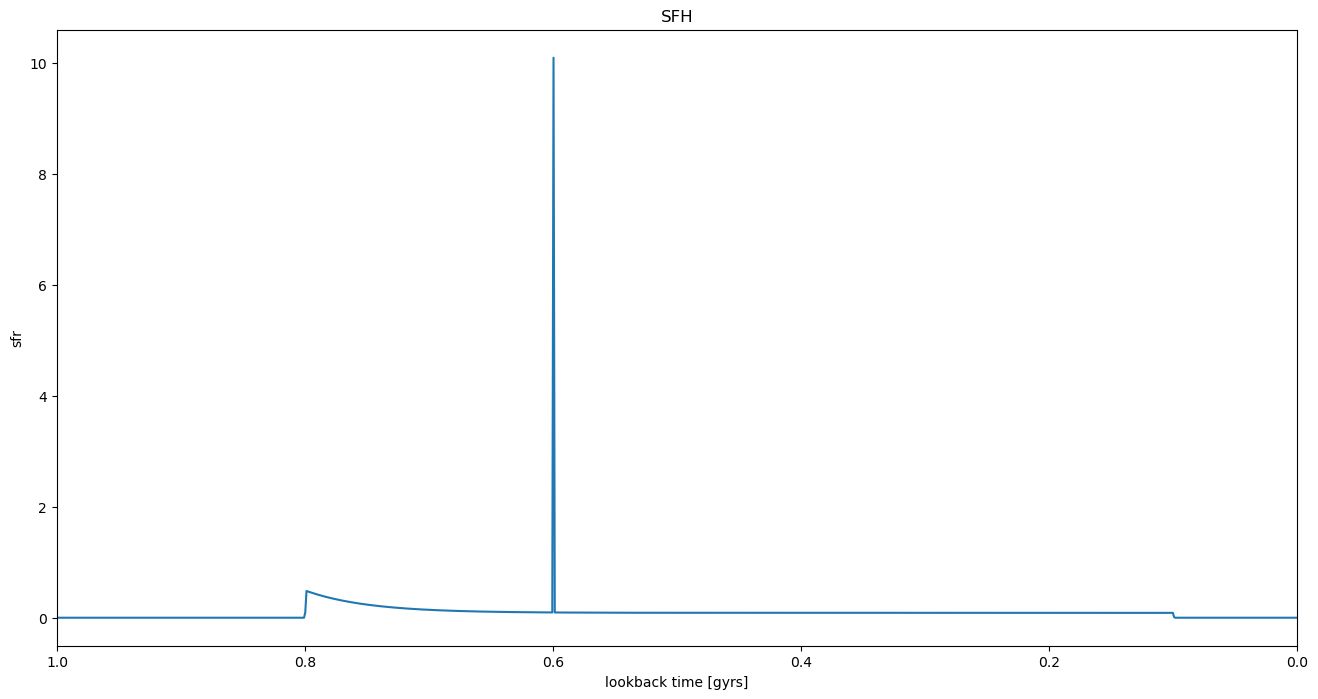

In [147]:
figure(figsize=(16,8))

times = np.linspace(0,run_params['tage'],1000)

sfrs = parametric_sfr(times=times,**run_params)
plot(times,sfrs)

xlabel('lookback time [gyrs]')
ylabel('sfr')

xlim([times[-1],times[0]])

title('SFH')

show()

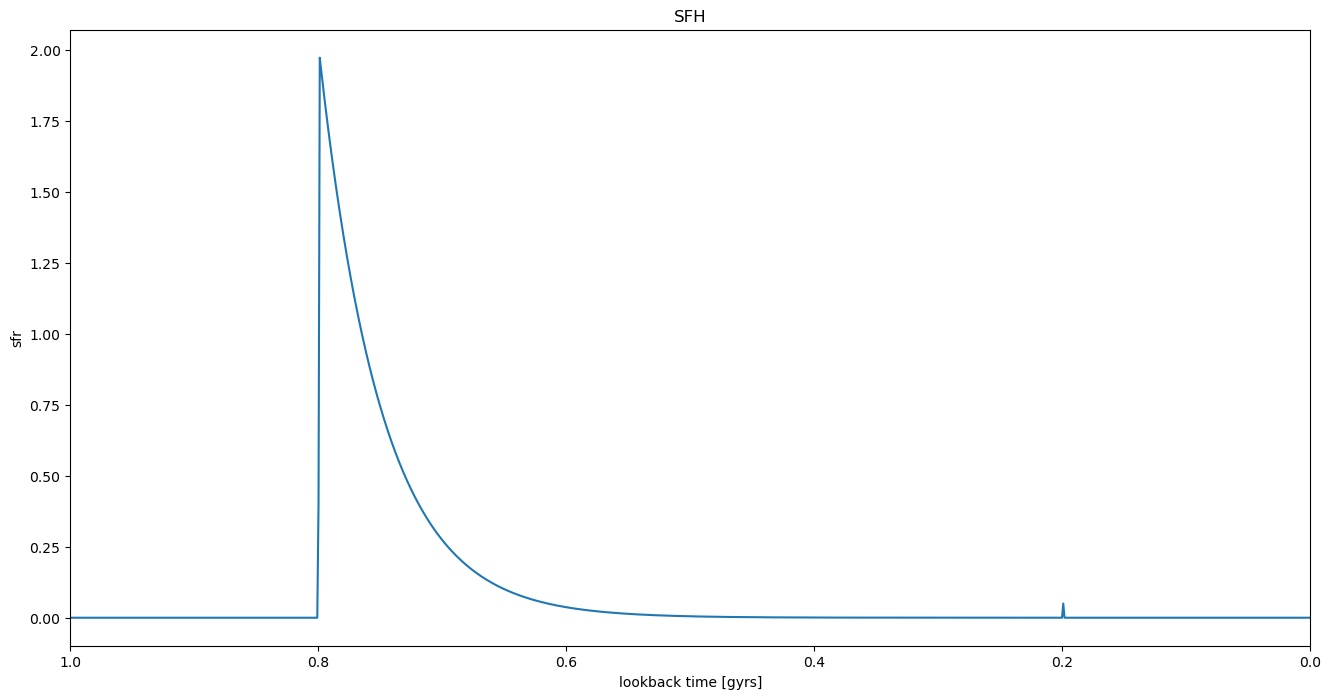

In [98]:
figure(figsize=(16,8))

times = np.linspace(0,run_params['tage'],1000)

sfrs = parametric_sfr(times=times,**run_params)
plot(times,sfrs)

xlabel('lookback time [gyrs]')
ylabel('sfr')

xlim([times[-1],times[0]])

title('SFH')

show()

In [228]:
def model_function(add_burst=False, trunc=False, **extras):

    from prospect.models import SpecModel
    from prospect.models.templates import TemplateLibrary

    model_params = TemplateLibrary['parametric_sfh']

    if add_burst:
        model_params.update(TemplateLibrary['burst_sfh'])
        model_params['const'] = {'N': 1, 'isfree': False, 'init': 0.0, 'units': 'Solar Masses per year'}
        if trunc:
            model_params['sf_start'] = {'N': 1, 'isfree': False, 'init': 0.0, 'units': 'Gyrs'}
            model_params['sf_trunc'] = {'N': 1, 'isfree': False, 'init': 0.0, 'units': 'Gyrs'}

    for key in list(extras.keys()):
        model_params[key]['init'] = extras[key]

    model = SpecModel(model_params)
    
    return model

-------------------
#### Plotting individual spectra alongside their SFH to make sure what I am doing works

In [236]:
run_params = {}
run_params['zred'] = 3.548
run_params['mass'] = 1e8
run_params['logzsol'] = 0.0 # Solar metallicity
run_params['dust2'] = 0.0
run_params['sfh'] = 1 # tau model plus a constant component and a burst
run_params['tage'] = 1 # The age of the host (galaxy) in Gyrs
run_params['imf_type'] = 2 # (Kroupa 2001)
run_params['tau'] = .05 # The e-folding time for the SFH, range is 1e-1 to 1e2

run_params['add_burst'] = True
# run_params['tburst']
run_params['fburst'] = 0.001 # The fraction of mass formed in an instantaneous burst of star formation
run_params['fage_burst'] = .9999 # The fraction of the host age at which the burst occurred.
run_params['tburst'] = tburst_from_fage(**run_params) # The age of the universe (age of the host) when the burst occurred

run_params['const'] =  0.8 - run_params['fburst']

run_params['trunc'] = False
# run_params['sf_start'] = 0.2 # Start time of the SFH in Gyrs
# run_params['sf_trunc'] = 0.9 # Trunctation time of the SFH in Gyrs. 0.0 => no trunctation
# run_params['sf_slope'] # For sfh=5, this is the slope of the SFR *after* time sf_trunc

obs = getObs()
sps = getSps(**run_params)

wspec = sps.wavelengths

In [237]:
N = 2 # Number of plots we're making to test

fbursts = [0.001, .6]
print(fbursts)

specs = np.empty((N,len(wspec)))

n=0
for f in tqdm(fbursts):
    run_params['fburst'], run_params['const'] = f, .8 - f
    model = model_function(**run_params)
    spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
    specs[n] = spec
    n+=1
print('done')

[0.001, 0.6]


  0%|                                                                                   | 0/2 [00:00<?, ?it/s]

0.001 0.799


100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:55<00:00, 27.68s/it]

0.6 0.20000000000000007
done


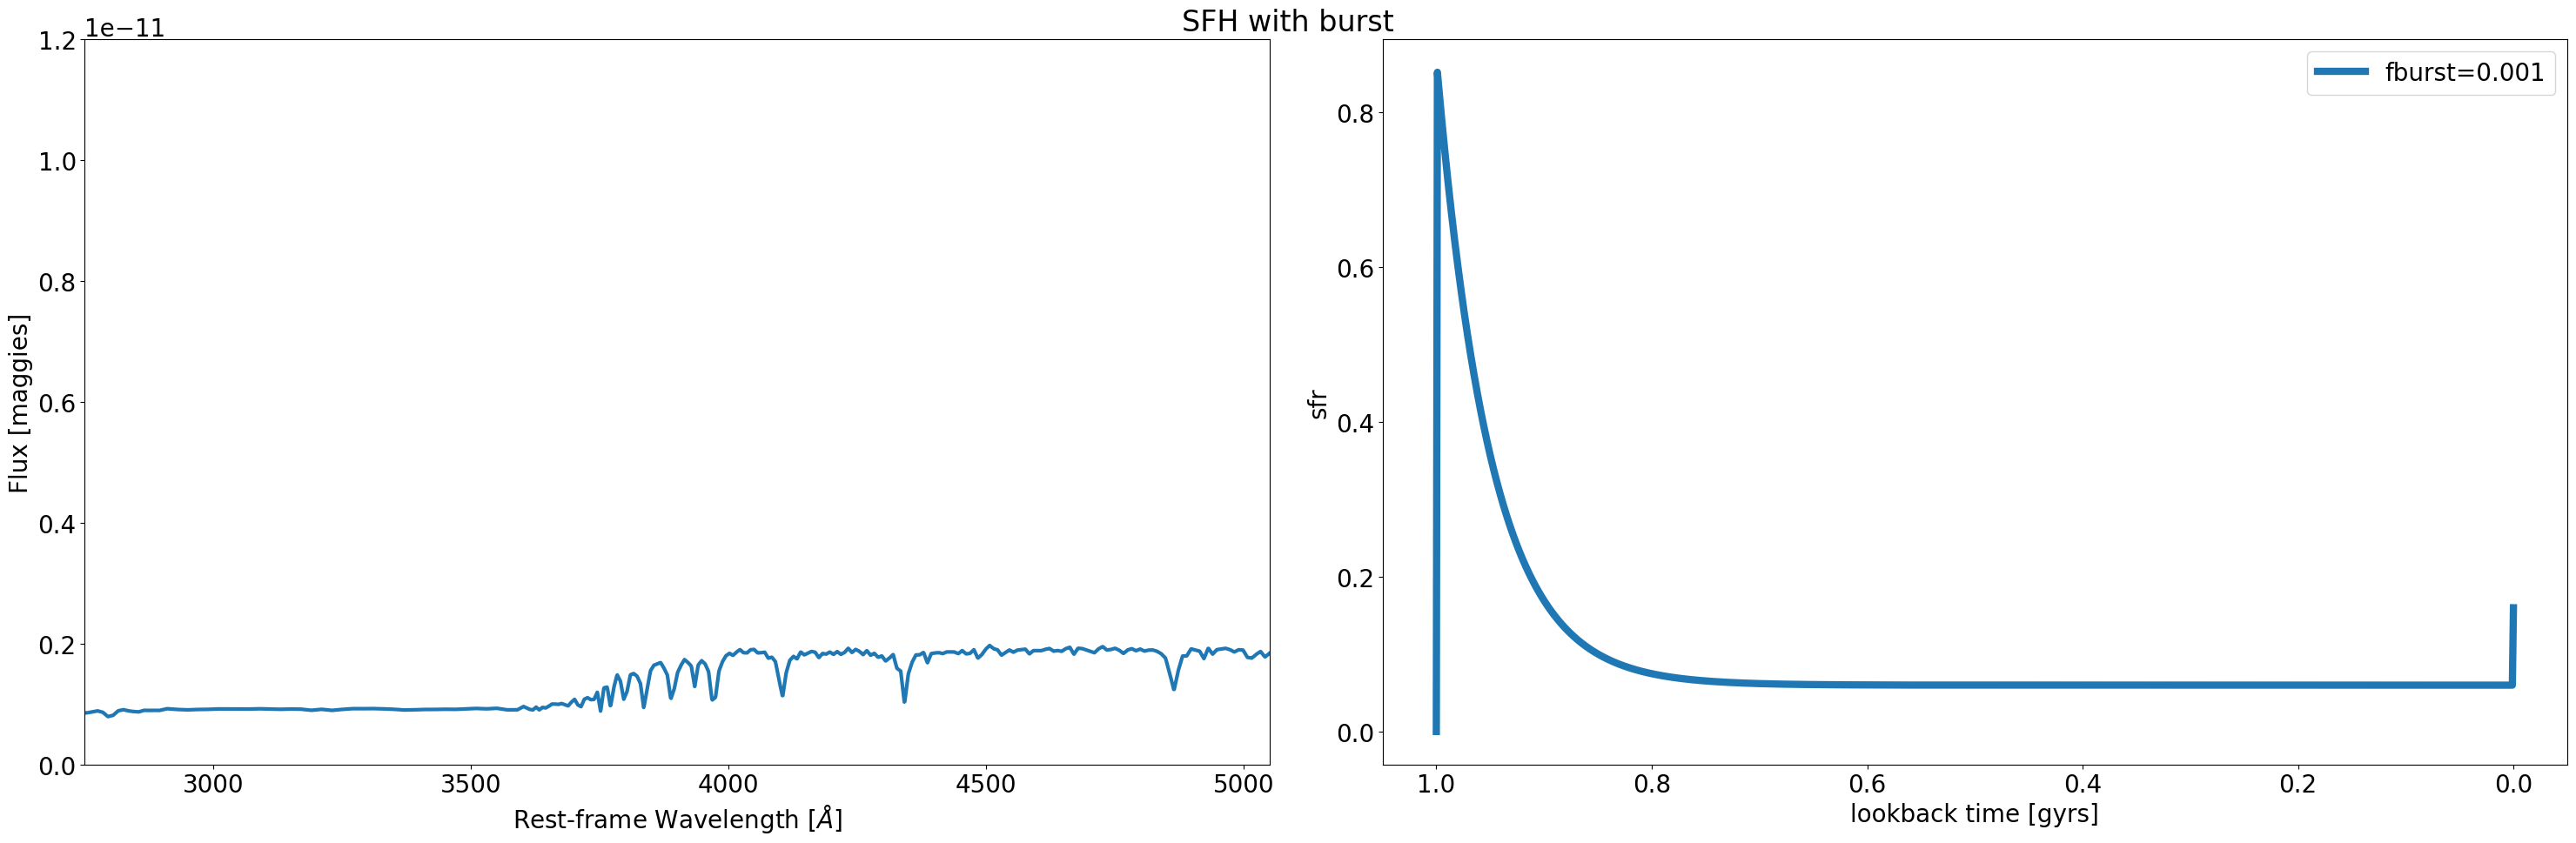

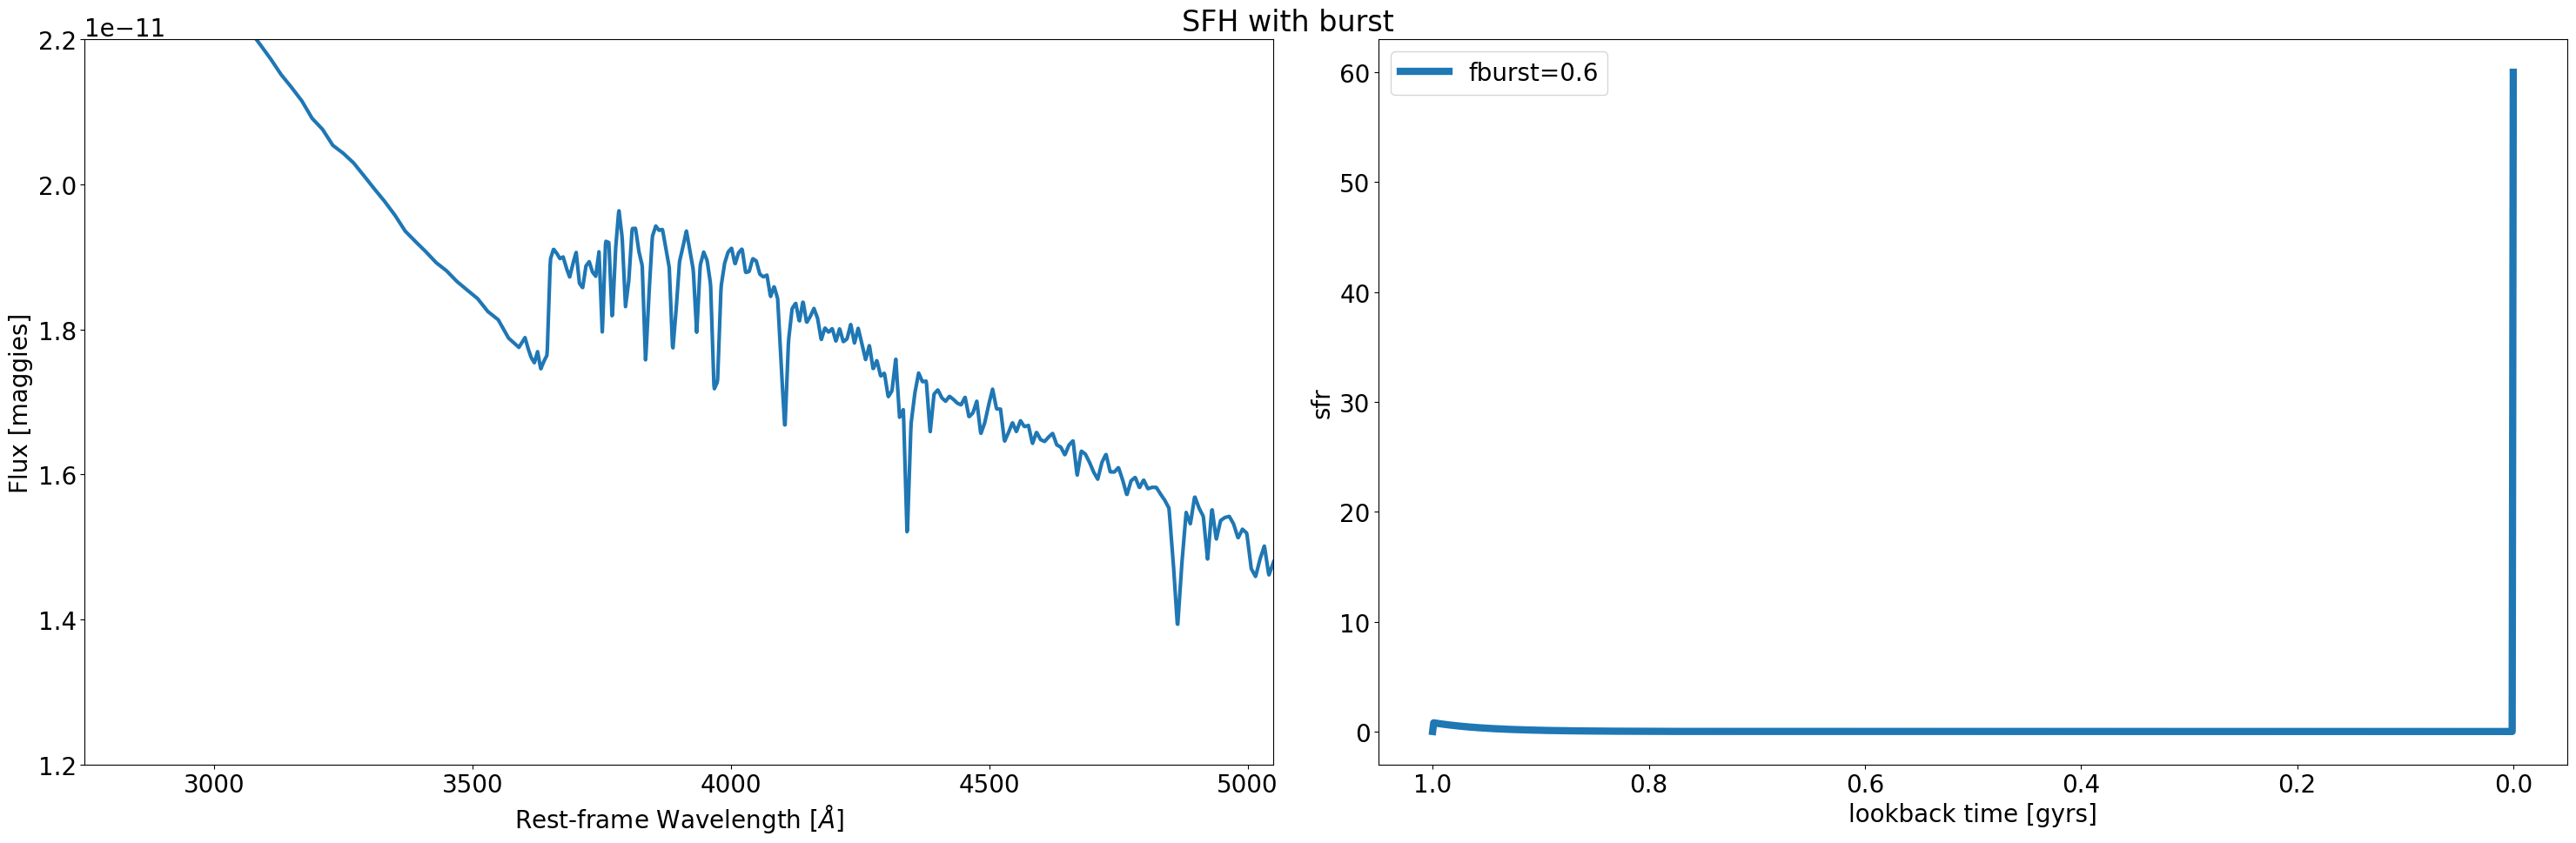

In [267]:
times = np.linspace(0,run_params['tage'],1000)

rcParams['font.size'] = 20

# fig, [ax1,ax2] = subplots(1,2,figsize=(28*2,7*2))
n=1
for spec, f in zip(specs, fbursts):

    fig, [ax1,ax2] = subplots(1,2,figsize=(30,10))
    ax1.plot(wspec, spec, lw=3)
    ax1.set_xlabel(r'Rest-frame Wavelength [$\AA$]')
    ax1.set_ylabel('Flux [maggies]')
    ax1.set_xlim([2750,5050])
    if n==1:
        ax1.set_ylim([0.0,1.2e-11])
    elif n==2:
        ax1.set_ylim([1.2e-11,2.2e-11])
    # ax1.set_yscale('log')

    run_params['fburst'], run_params['const'] = f, .6 - f

    # print(run_params)
    sfrs = parametric_sfr(times=times,**run_params)
    
    ax2.plot(times,sfrs, lw=6, label=f'fburst={f}')
    ax2.set_xlabel('lookback time [gyrs]')
    ax2.set_ylabel('sfr')
    ax2.set_xlim([times[-1]+.05,times[0]-.05])

    ax2.legend()

    tight_layout()
    fig.suptitle(f'SFH with burst')
    n+=1
    
    # savefig(f'check_{n}.png')

show()

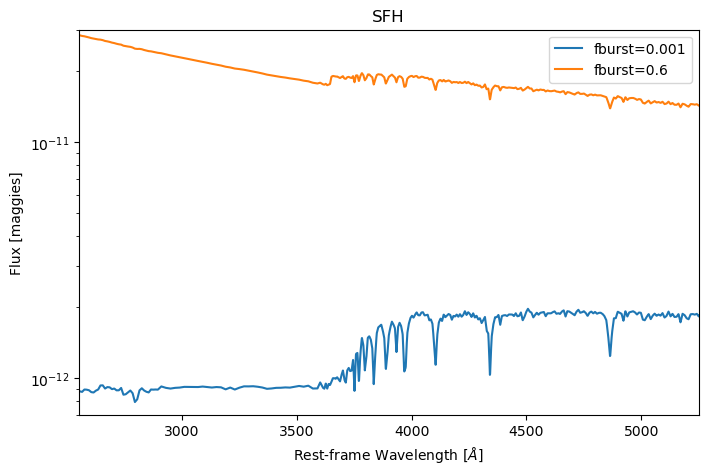

In [291]:
rcParams['font.size'] = 10
figure(figsize=(8,5))

for n,spec in enumerate(specs):
    loglog(wspec, spec, label=f'fburst={fbursts[n]}')

xscale('linear')
xlim([2550,5250])
ylim([7.0e-13,3.0e-11])

xlabel(r'Rest-frame Wavelength [$\AA$]')
ylabel('Flux [maggies]')

title('SFH')
legend()

show()

--------------------


#### TESTING


---------------------

In [ ]:
for spec, f in zip(specs, fbursts):

    fig, [ax1,ax2] = subplots(1,2,figsize=(28,7))
    ax1.loglog(wspec, spec)
    ax1.set_xlabel(r'Rest-frame Wavelength [$\AA$]')
    ax1.set_ylabel('Flux [maggies]')

    run_params['fburst'] = f

    print(run_params)
    sfrs = parametric_sfr(times=times,**run_params)
    
    ax2.plot(times,sfrs, label=f'fburst={f}')
    ax2.set_xlabel('lookback time [gyrs]')
    ax2.set_ylabel('sfr')
    ax2.set_xlim([times[-1],times[0]])
    ax2.set_title('SFH')

    ax2.legend()

    show()